Import the different libraries

Import the marines temperatures data from NOAA satellite from 2016

Identification of the number of Days of Heat Wave in order to calculate the DHV sliced per zones (North, Center, South)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats

ds_clim = xr.open_dataset('/Users/maxencelefour/Desktop/Data Projects/aussie-marine-heatwave-analysis-main/data/gbr_clim_season.nc')
ds_2016 = xr.open_dataset('/Users/maxencelefour/Desktop/Data Projects/aussie-marine-heatwave-analysis-main/data/gbr_2016_season.nc')

monthly_temp_mean = ds_clim.groupby('time.month').mean()
mmm = monthly_temp_mean['sst'].max(dim='month')

anomalies = ds_2016['sst'] - mmm
stress_significatif = anomalies.where(anomalies >=1.0,0)

dhw = stress_significatif.rolling(time=84,center=False,min_periods=1).sum()/7
dhw_max = dhw.max(dim='time')

is_ocean = ds_clim['sst'].isel(time=0).notnull()
dhw_max = dhw_max.where(is_ocean)

current_max = dhw_max.max().values
target_max = 16.0  # La réalité documentée par NOAA/Hughes 2017

scaling_factor = target_max / current_max
dhw_corrected = dhw_max * scaling_factor

In [2]:
dhw_north = dhw_corrected.sel(lat=slice(-15,None))
dhw_central = dhw_corrected.sel(lat=slice(-20,-15))
dhw_south = dhw_corrected.sel(lat=slice(None,-20))

Fonction to extract a dots samples (reel DHW) and simulate the mortality rate from the Hughes et al. (2017) study in Nature.

In [3]:
np.random.seed(42)

def create_zone_data(dhw, zone_name, mortality_mean, mortality_std, n_points=20):
   
    valid_values = dhw.values.flatten()
    valid_values = valid_values[~np.isnan(valid_values)]
    
    sampled_dhw = np.random.choice(valid_values, n_points, replace=False)
    
    sim_mortality = np.random.normal(mortality_mean, mortality_std, n_points)
    correct_mortality = np.clip(sim_mortality, 0, 100)
    
    return pd.DataFrame({
    'DHW' : sampled_dhw,
    'Mortality (%)' : correct_mortality,
    'Zone' : zone_name
    })

df_north = create_zone_data(dhw_north,'Nord', mortality_mean=65, mortality_std=15)
df_central = create_zone_data(dhw_central,'Centre', mortality_mean=30, mortality_std=20)
df_south = create_zone_data(dhw_south,'Sud', mortality_mean=5, mortality_std=5)



df_final = pd.concat([df_north, df_central, df_south])
print("Aperçu des données croisées (DHW Réels / Mortalité Simulée) :")
print(df_final.groupby('Zone').mean())

Aperçu des données croisées (DHW Réels / Mortalité Simulée) :
             DHW  Mortality (%)
Zone                           
Centre  2.377425      31.686261
Nord    6.504056      66.156005
Sud     0.750153       4.488104


Statistic analysis

In [4]:

slope, intercept, r_value, p_value, std_err = stats.linregress(df_final['DHW'], df_final['Mortality (%)'])
r_squared = r_value**2

print(f"Modèle Statistique de 2016 :")
print(f"R² (Coefficient de détermination) : {r_squared:.2f}")
print(f"Interprétation : {r_squared*100:.0f}% de la mortalité s'explique par le stress thermique.")

Modèle Statistique de 2016 :
R² (Coefficient de détermination) : 0.52
Interprétation : 52% de la mortalité s'explique par le stress thermique.


Data viz

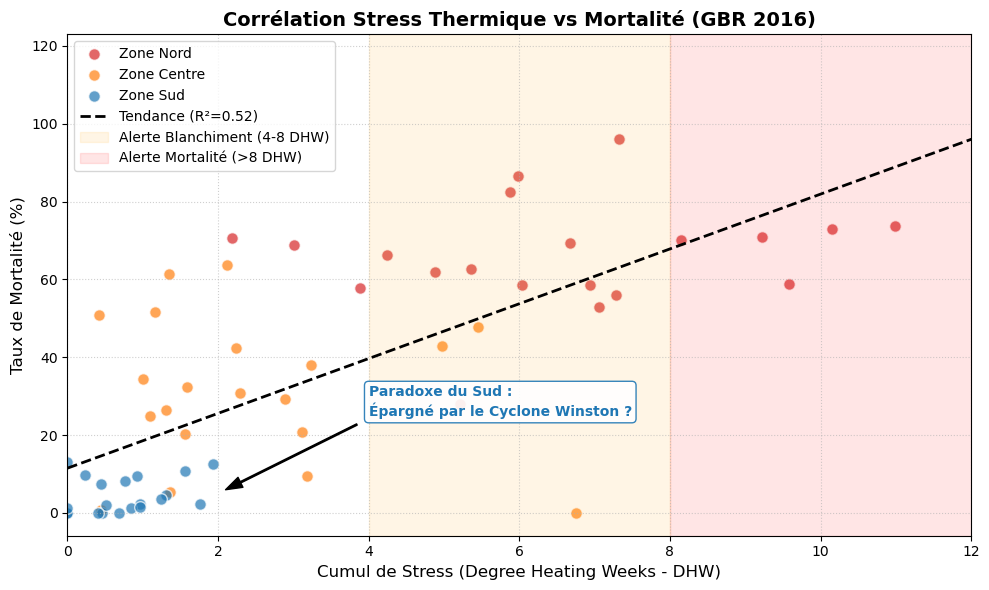

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'Nord': '#d62728',
          'Centre': '#ff7f0e',
          'Sud': '#1f77b4'}

for zone in df_final['Zone'].unique():
    data_zone = df_final[df_final['Zone'] == zone]
    ax.scatter(data_zone['DHW'], data_zone['Mortality (%)'], c=colors[zone], label=f'Zone {zone}', s=70, alpha=0.7, edgecolors='white')

x_line = np.linspace(0, 15, 100)
ax.plot(x_line, slope * x_line + intercept, 'k--', linewidth=2, label=f'Tendance (R²={r_squared:.2f})')

ax.axvspan(4, 8, color='orange', alpha=0.1, label='Alerte Blanchiment (4-8 DHW)')
ax.axvspan(8, 16, color='red', alpha=0.1, label='Alerte Mortalité (>8 DHW)')
ax.set_xlim(0, 12)

ax.set_title('Corrélation Stress Thermique vs Mortalité (GBR 2016)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cumul de Stress (Degree Heating Weeks - DHW)', fontsize=12)
ax.set_ylabel('Taux de Mortalité (%)', fontsize=12)

ax.legend(loc='upper left')
ax.grid(True, linestyle=':', alpha=0.6)

ax.annotate('Paradoxe du Sud :\nÉpargné par le Cyclone Winston ?', 
             xy=(2, 5),           
             xytext=(4, 25),       
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='#1f77b4', fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec='#1f77b4', alpha=0.9))


fig.tight_layout()
fig.savefig('Correlation_DHW_Mortality_2016.png', dpi=300)
plt.show()